<a href="https://colab.research.google.com/github/veydantkatyal/VerifAI/blob/main/Image_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##Install Libraries

In [2]:
!pip install timm  # Install timm for Xception model




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
import torch
import torchvision
import timm  # For Xception model
import random
import os
import zipfile
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


In [ ]:
!ls /content/


dataset  deepfake-and-real-images.zip  drive  sample_data


##Uploading kaggle data using api

In [ ]:
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vrindabajaj20","key":"1a17acebfdbd707714213efd634f469f"}'}

In [ ]:
import os
os.makedirs("/root/.kaggle", exist_ok=True)
os.rename("kaggle.json", "/root/.kaggle/kaggle.json")


#Downloading dataset

In [ ]:
!kaggle datasets download -d manjilkarki/deepfake-and-real-images


Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
deepfake-and-real-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip deepfake-and-real-images.zip -d /content/dataset/


Archive:  deepfake-and-real-images.zip
replace /content/dataset/Dataset/Test/Fake/fake_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import os
print(os.listdir('/content/dataset/'))


['Dataset']


In [ ]:
import os
print(os.listdir('/content/dataset/Dataset'))


['Train', 'Validation', 'Test']


####gpu availability

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#Image preprocessing ( transformations)

In [ ]:
# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize the images to 299x299 as required by Xception
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization for pre-trained models
])
'''train_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Xception requires 299x299 images
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])'''


'train_transform = transforms.Compose([\n    transforms.Resize((299, 299)),  # Xception requires 299x299 images\n    transforms.RandomHorizontalFlip(),\n    transforms.ToTensor(),\n    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])\n])\n\nval_transform = transforms.Compose([\n    transforms.Resize((299, 299)),\n    transforms.ToTensor(),\n    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])\n])'

#Training and test data

In [ ]:
from torchvision import datasets, models, transforms
train_dir = '/content/dataset/Dataset/Train'  # Specify the train folder path
valid_dir = '/content/dataset/Dataset/Validation'  # Specify the validation folder path
test_dir = '/content/dataset/Dataset/Test'  # Specify the test folder path

# Create training and validation datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
valid_dataset = datasets.ImageFolder(root=valid_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Step 4: Check the dataset class distribution (optional)
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(valid_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 140002
Validation set size: 39428
Test set size: 10905


size of the training data

In [ ]:
# Step 5: Split the datasets to use only 2000 samples for training, and 500 for validation and test each
train_samples = 1500
valid_samples = 300
test_samples = 300

# Using random splits
train_dataset, _ = torch.utils.data.random_split(train_dataset, [train_samples, len(train_dataset) - train_samples])
valid_dataset, _ = torch.utils.data.random_split(valid_dataset, [valid_samples, len(valid_dataset) - valid_samples])
test_dataset, _ = torch.utils.data.random_split(test_dataset, [test_samples, len(test_dataset) - test_samples])

#data loader

In [ ]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import pandas as pd
labels = [label for _, label in train_dataset]  # Extract labels from the train dataset
labels_df = pd.DataFrame(labels, columns=['label'])  # Create a DataFrame to count labels

# Get the value counts (counts of each label)
label_counts = labels_df['label'].value_counts()

# Print the counts of each label (assuming 0 and 1 as possible labels)
print("Label 0 count:", label_counts.get(0, 0))
print("Label 1 count:", label_counts.get(1, 0))

Label 0 count: 759
Label 1 count: 741


In [ ]:
class_names = train_dataset.dataset.classes
print("Class names:", class_names)

Class names: ['Fake', 'Real']


##Fine tuning the pre trained model

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil
import timm

model = timm.create_model("xception", pretrained=True)

# Step 8: Modify the final layer for binary classification (Real vs Fake)
model.fc = nn.Linear(model.fc.in_features, 2)  # We have 2 classes: Real and Fake

# Send the model to the GPU (if available)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


#loss function and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

#training loop

In [ ]:
def train_model(model, train_loader, valid_loader, epochs=5):
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")

        for images, labels in train_loader_iter:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero out gradients

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            loss.backward()  # Backpropagation
            optimizer.step()  # Optimizer step to update weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_loader_iter.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        # Print training results
        train_acc = 100 * correct / total
        print(f"Epoch {epoch+1}: Train Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_acc:.2f}%")

        # Validate after each epoch
        validate_model(model, valid_loader)

# Step 11: Define the validation loop
def validate_model(model, valid_loader):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradients needed for validation
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print validation results
    val_acc = 100 * correct / total
    print(f"Validation Loss: {running_loss / len(valid_loader):.4f}, Validation Accuracy: {val_acc:.2f}%")


In [ ]:
train_model(model, train_loader, valid_loader, epochs=2)

Epoch 1/2 [Training]: 100%|██████████| 94/94 [00:44<00:00,  2.12it/s, accuracy=85.1, loss=0.169]


Epoch 1: Train Loss: 0.3548, Train Accuracy: 85.13%
Validation Loss: 0.2997, Validation Accuracy: 87.00%


Epoch 2/2 [Training]: 100%|██████████| 94/94 [00:45<00:00,  2.08it/s, accuracy=96.6, loss=0.314]


Epoch 2: Train Loss: 0.0972, Train Accuracy: 96.60%
Validation Loss: 0.3233, Validation Accuracy: 88.33%


In [ ]:
print("Evaluating on Test set:")
validate_model(model, test_loader)

Evaluating on Test set:
Validation Loss: 0.3115, Validation Accuracy: 88.67%


#Predicting real or fake

In [ ]:
import torch
from google.colab import files
from torchvision import transforms
from PIL import Image

# Define the transformations (same as used during training)
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Xception expects 299x299 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization for ImageNet
])

# Load the trained model (ensure it's on the correct device)
model.eval()  # Set the model to evaluation mode

# Function to make predictions on a given image
def predict_image(image_path):
    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Apply the transformations to the image
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move the image to the same device as the model (GPU/CPU)
    image = image.to(device)

    # Make the prediction
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class

    # Output the result
    if predicted.item() == 1:
        print("The image is Real.")
    else:
        print("The image is Fake.")

# Example usage: pass the image path to test
uploaded = files.upload()

# Get the file name of the uploaded image
image_path = next(iter(uploaded))

# Predict the uploaded image
predict_image(image_path)


Saving human.jpeg to human.jpeg
The image is Fake.


In [ ]:
print(model)

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

##saving the model

In [ ]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'fake_real_model.pth')

##creating class

#implementing grad cam on the fine tuned model - class

Saving lakshya.jpg to lakshya.jpg


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


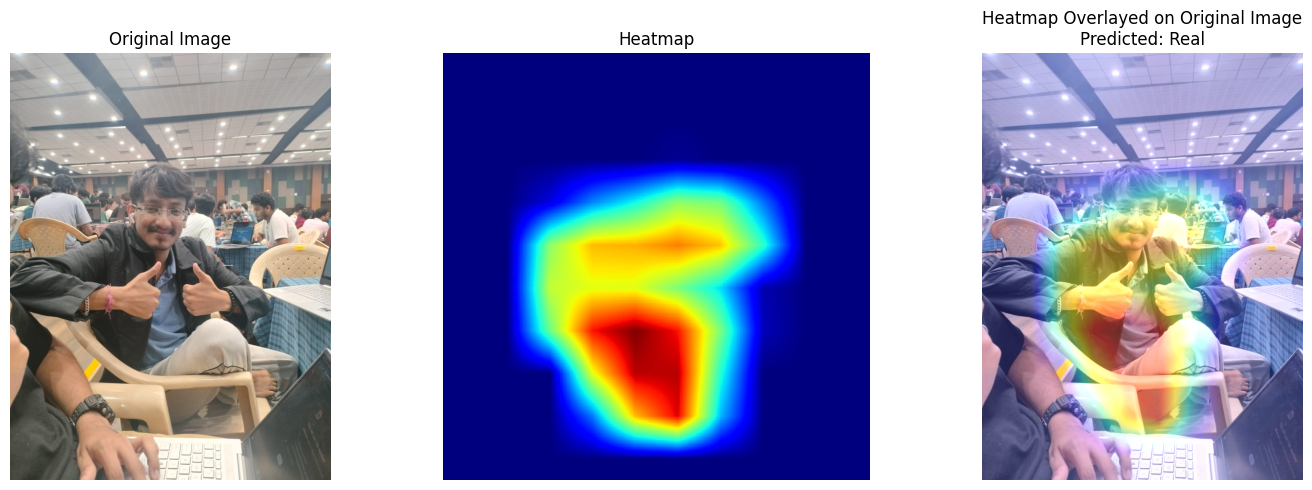

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import timm

# Define the transformations (same as used during training)
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Xception expects 299x299 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization for ImageNet
])

# Load the image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image, image_tensor.to(device)

# Grad-CAM implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def hook_fn_backward(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        def hook_fn_forward(module, input, output):
            self.activations = output

        self.target_layer.register_forward_hook(hook_fn_forward)
        self.target_layer.register_backward_hook(hook_fn_backward)

    def generate_cam(self, input_image, target_class=None):
        # Forward pass
        output = self.model(input_image)
        if target_class is None:
            target_class = np.argmax(output.cpu().data.numpy())

        # Backward pass
        self.model.zero_grad()
        one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_().to(device)
        one_hot_output[0][target_class] = 1
        output.backward(gradient=one_hot_output)

        # Generate CAM
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=(299, 299), mode='bilinear', align_corners=False)
        cam = cam - cam.min()
        cam = cam / cam.max()
        return cam.cpu().data.numpy()[0, 0], target_class

# Function to overlay heatmap on the original image
def overlay_heatmap(image, heatmap):
    # Resize heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (image.size[0], image.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply colormap
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert to RGB
    superimposed_img = heatmap * 0.4 + np.array(image)  # Overlay heatmap on the original image
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    return Image.fromarray(superimposed_img)

# Define your custom wrapper class
class FakeRealModel(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        """
        Initialize the FakeRealModel.

        Args:
            num_classes (int): Number of output classes (default: 2 for binary classification).
            pretrained (bool): Whether to use a pretrained Xception model (default: True).
        """
        super(FakeRealModel, self).__init__()

        # Load the Xception model
        self.model = timm.create_model("xception", pretrained=pretrained)

        # Modify the final layer for binary classification
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 3, height, width).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_classes).
        """
        return self.model(x)

# Function to save the results
def save_results(original_image, heatmap, overlayed_image, predicted_class, output_dir="output"):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save the original image
    original_image.save(os.path.join(output_dir, "original_image.jpg"))

    # Save the heatmap
    plt.imshow(heatmap, cmap='jet')
    plt.axis('off')
    plt.savefig(os.path.join(output_dir, "heatmap.jpg"), bbox_inches='tight', pad_inches=0)
    plt.close()

    # Save the heatmap-overlayed image
    overlayed_image.save(os.path.join(output_dir, "overlayed_image.jpg"))



# Example usage
if __name__ == "__main__":
    # Create an instance of the FakeRealModel
    model = FakeRealModel(num_classes=2, pretrained=False)

    # Load the state dictionary and modify keys
    state_dict = torch.load('fake_real_model.pth', weights_only=True)
    new_state_dict = {f"model.{k}": v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict)

    # Move the model to the device and set to evaluation mode
    model = model.to(device)
    model.eval()

    # Specify the target layer for Grad-CAM
    target_layer = model.model.conv4  # You can change this to any convolutional layer

    # Initialize Grad-CAM
    grad_cam = GradCAM(model, target_layer)

    # Load and preprocess the image
    uploaded = files.upload()

    # Get the file name of the uploaded image
    image_path = next(iter(uploaded))
    original_image, input_image = load_image(image_path)

    # Generate the heatmap and get the predicted class
    heatmap, predicted_class = grad_cam.generate_cam(input_image)

    # Overlay the heatmap on the original image
    overlayed_image = overlay_heatmap(original_image, heatmap)

    # Save the results
    save_results(original_image, heatmap, overlayed_image, predicted_class, output_dir="output")

    # Display the three states
    plt.figure(figsize=(15, 5))

    # 1. Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    # 2. Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Heatmap")
    plt.axis('off')

    # 3. Heatmap Overlayed on Original Image
    plt.subplot(1, 3, 3)
    plt.imshow(overlayed_image)
    plt.title(f"Heatmap Overlayed on Original Image\nPredicted: {'Real' if predicted_class == 1 else 'Fake'}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

#save the file

In [ ]:
import torch


model_save_path = "image_fake_or_real_model_with_gradcam.pth"
torch.save(model.state_dict(), model_save_path)  # Saves only the learned parameters (weights)


print(f"✅ Model Saved Successfully at {model_save_path}")



✅ Model Saved Successfully at image_fake_or_real_model_with_gradcam.pth
